In [3]:
!pip install --user torch --upgrade


     -------------------------------------- 216.1/216.1 MB 5.5 MB/s eta 0:00:00
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)


In [7]:
!pip install wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


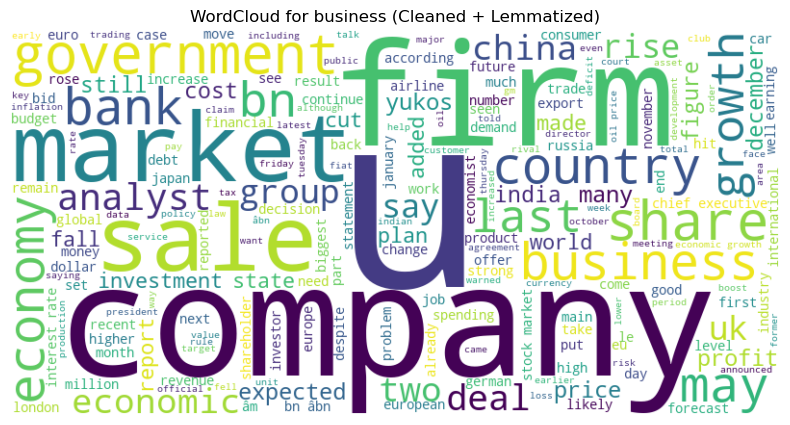

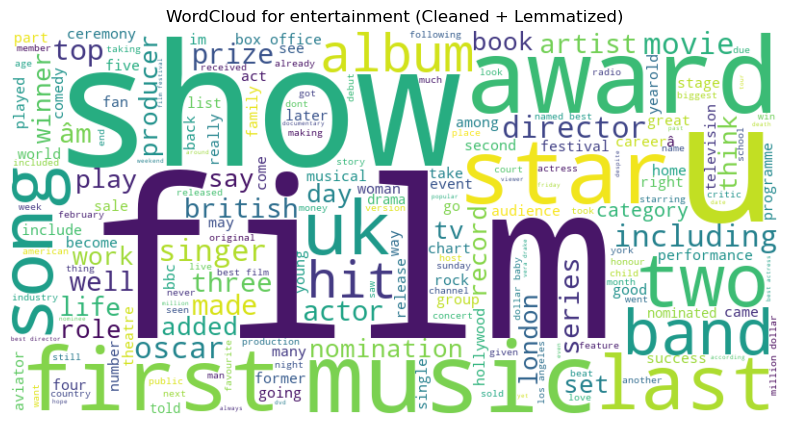

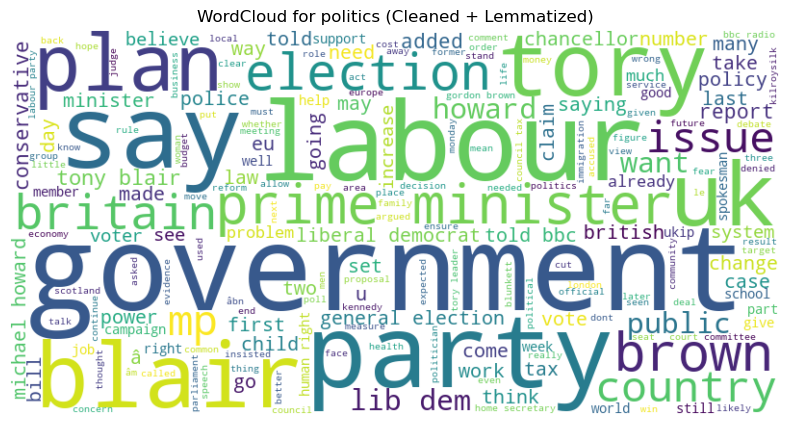

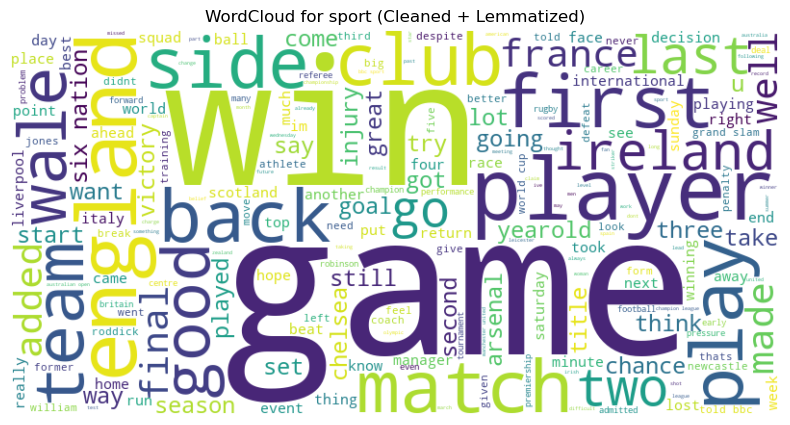

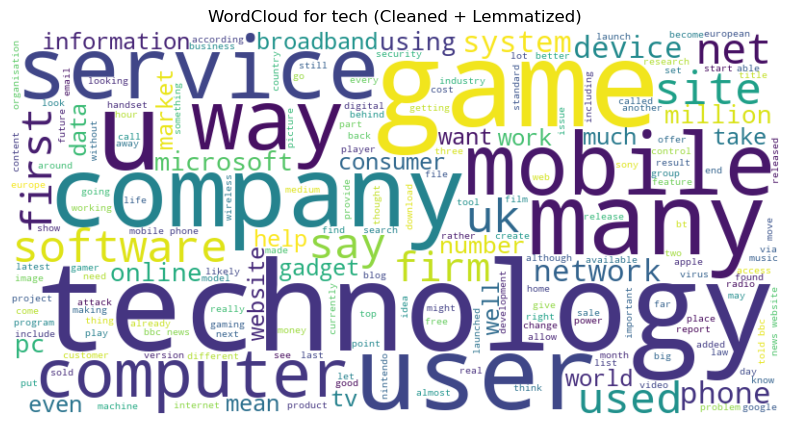


Top 50 terms found for category 'business':
['analyst' 'bank' 'bn' 'business' 'chief' 'china' 'company' 'cost'
 'country' 'cut' 'deal' 'december' 'dollar' 'economic' 'economy' 'euro'
 'executive' 'expected' 'figure' 'financial' 'firm' 'government' 'group'
 'growth' 'however' 'investment' 'job' 'last' 'market' 'may' 'month' 'oil'
 'price' 'profit' 'rate' 'report' 'rise' 'sale' 'say' 'share' 'since'
 'state' 'stock' 'tax' 'two' 'uk' 'world' 'yukos' 'âbn' 'âm']

Top 50 terms found for category 'entertainment':
['actor' 'actress' 'album' 'award' 'band' 'bbc' 'best' 'british' 'chart'
 'comedy' 'day' 'director' 'festival' 'film' 'first' 'hit' 'including'
 'last' 'life' 'made' 'million' 'movie' 'music' 'nomination' 'number'
 'oscar' 'place' 'play' 'prize' 'record' 'rock' 'role' 'sale' 'series'
 'show' 'singer' 'single' 'song' 'star' 'three' 'top' 'tv' 'two' 'uk'
 'week' 'well' 'win' 'winner' 'world' 'âm']

Top 50 terms found for category 'politics':
['bbc' 'blair' 'britain' 'british' 'brown'

In [10]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load BBC dataset
def load_bbc_dataset(dataset_path):
    data = []
    for category in os.listdir(dataset_path):
        cat_path = os.path.join(dataset_path, category)
        if not os.path.isdir(cat_path):
            continue
        for file in os.listdir(cat_path):
            with open(os.path.join(cat_path, file), 'r', encoding='latin1') as f:
                text = f.read()
                text = BeautifulSoup(text, "html.parser").get_text()
                data.append({"category": category, "text": text})
    return pd.DataFrame(data)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    stop_words = set(stopwords.words('english'))
    additional_stopwords = set(['said', 'mr', 'new', 'year', 'years', 'like', 'make', 'use', 'people', 'just', 'also', 'could', 'would', 'one', 'time'])
    all_stopwords = stop_words.union(additional_stopwords)
    words = [word for word in text.split() if word not in all_stopwords]
    return ' '.join(words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Load and clean data
df = load_bbc_dataset(r"C:\Users\User\OneDrive\Desktop\BBC\data\bbc-fulltext\bbc")
df['clean_text'] = df['text'].apply(clean_text)
df['clean_text'] = df['clean_text'].apply(lemmatize_text)

# Generate WordCloud per category on cleaned + lemmatized text
for category in df['category'].unique():
    text = " ".join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {category} (Cleaned + Lemmatized)')
    plt.show()

    
# Prepare stopwords
stop_words = set(stopwords.words('english'))
additional_stopwords = set(['said', 'mr', 'new', 'year', 'years', 'like', 'make', 'use', 'people', 'just'])
all_stopwords = stop_words.union(additional_stopwords)

# Use list instead of set
vectorizer = CountVectorizer(stop_words=list(all_stopwords), max_features=50)

for category in df['category'].unique():
    texts = df[df['category'] == category]['clean_text']
    X = vectorizer.fit_transform(texts)
    print(f"\nTop 50 terms found for category '{category}':")
    print(vectorizer.get_feature_names_out())
    

In [19]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load BBC dataset
def load_bbc_dataset(dataset_path):
    data = []
    for category in os.listdir(dataset_path):
        cat_path = os.path.join(dataset_path, category)
        if not os.path.isdir(cat_path):
            continue
        for file in os.listdir(cat_path):
            with open(os.path.join(cat_path, file), 'r', encoding='latin1') as f:
                text = f.read()
                text = BeautifulSoup(text, "html.parser").get_text()
                data.append({"category": category, "text": text})
    return pd.DataFrame(data)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    stop_words = set(stopwords.words('english'))
    additional_stopwords = set(['said', 'mr', 'new', 'year', 'years', 'like', 'make', 'use', 'people', 'just', 'also', 'could', 'would', 'one', 'time', 'government', 'company', 'minister', 'team'])
    all_stopwords = stop_words.union(additional_stopwords)
    words = [word for word in text.split() if word not in all_stopwords]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Load and clean data
df = load_bbc_dataset(r"C:\Users\User\OneDrive\Desktop\BBC\data\bbc-fulltext\bbc")
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(subset='text')
print(f"After removing duplicates: {df.shape}")
df['clean_text'] = df['text'].apply(clean_text)

# Fit LDA models with enhanced settings
lda_models = {}
dictionaries = {}
categories = ['business', 'entertainment', 'sport', 'politics', 'tech']

for category in categories:
    print(f"Fitting LDA for {category}")
    texts = df[df['category'] == category]['clean_text'].tolist()
    processed_texts = [simple_preprocess(doc, deacc=True) for doc in texts]
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    num_topics = 12 if category in ['business', 'politics'] else 10
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=20)
    lda_models[category] = lda_model
    dictionaries[category] = dictionary
    print(f"Top topics for {category}:")
    print(lda_model.print_topics())

# Compute coherence scores
for category in categories:
    texts = df[df['category'] == category]['clean_text'].tolist()
    processed_texts = [simple_preprocess(doc, deacc=True) for doc in texts]
    dictionary = dictionaries[category]
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    lda_model = lda_models[category]
    coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(f"Coherence Score for {category}: {coherence:.4f}")

# Subcategory mapping
subcategory_mapping = {
    'entertainment': {0: 'music', 1: 'cinema', 2: 'theatre', 3: 'television', 4: 'celebrity_news', 5: 'film_awards', 6: 'book_reviews', 7: 'TV_series', 8: 'concerts', 9: 'festival'},
    'business': {0: 'stock_market', 1: 'company_news', 2: 'mergers_acquisitions', 3: 'economic_policy', 4: 'oil_energy', 5: 'employment', 6: 'housing_market', 7: 'global_trade', 8: 'technology_business', 9: 'financial_markets'},
    'sport': {0: 'football', 1: 'cricket', 2: 'rugby', 3: 'tennis', 4: 'olympics', 5: 'athletics', 6: 'motorsport', 7: 'golf', 8: 'boxing', 9: 'cycling'},
    'politics': {0: 'elections', 1: 'government_policy', 2: 'party_politics', 3: 'international_relations', 4: 'parliament_news', 5: 'health_policy', 6: 'education_policy', 7: 'defense_policy', 8: 'immigration', 9: 'environment_policy'},
    'tech': {0: 'mobile_tech', 1: 'software', 2: 'internet', 3: 'hardware', 4: 'gaming', 5: 'cybersecurity', 6: 'AI_ML', 7: 'social_media', 8: 'telecom', 9: 'gadgets'}
}

# Assign subcategories
def assign_subcategory_labels(df, lda_models, dictionaries, subcategory_mapping):
    subcategories = []
    for idx, row in df.iterrows():
        category = row['category']
        tokens = row['clean_text'].split()
        bow = dictionaries[category].doc2bow(tokens)
        topic_probs = lda_models[category].get_document_topics(bow)
        if topic_probs:
            top_topic = max(topic_probs, key=lambda x: x[1])[0]
            subcat = subcategory_mapping[category].get(top_topic, f"{category}_topic_{top_topic}")
        else:
            subcat = "unknown"
        subcategories.append(subcat)
    df['subcategory'] = subcategories
    return df

df = assign_subcategory_labels(df, lda_models, dictionaries, subcategory_mapping)

# Named Entity Extraction with Roles
nlp = spacy.load("en_core_web_sm")
role_keywords = {
    "politician": ["minister", "mp", "senator", "president", "prime minister", "government"],
    "musician": ["singer", "band", "musician", "album", "song"],
    "actor": ["actor", "actress", "film", "movie", "tv"],
    "tv_personality": ["tv", "host", "presenter", "show"]
}

def extract_named_entities_with_roles(text):
    doc = nlp(text)
    persons = set([ent.text for ent in doc.ents if ent.label_ == "PERSON"])
    roles = {}
    for person in persons:
        lower_text = text.lower()
        assigned_role = "unknown"
        for role, keywords in role_keywords.items():
            if any(keyword in lower_text for keyword in keywords):
                assigned_role = role
                break
        roles[person] = assigned_role
    return roles

df['entities_with_roles'] = df['text'].apply(extract_named_entities_with_roles)

# Extract April event summaries
def extract_april_summary(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    april_sentences = [sent for sent in sentences if "april" in sent.lower()]
    return " ".join(april_sentences[:2]) if april_sentences else "None"

df['april_summary'] = df['text'].apply(extract_april_summary)

# Save final enriched dataset
df.to_csv("bbc_lda_final_named_subcategories2.csv", index=False)
print("Full LDA pipeline with precise subcategories, NER, and April summaries completed. Saved as 'bbc_lda_final_named_subcategories.csv'.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original shape: (2225, 2)
After removing duplicates: (2127, 2)
Fitting LDA for business
Top topics for business:
[(0, '0.012*"bank" + 0.007*"sri" + 0.006*"cost" + 0.005*"bn" + 0.005*"world" + 0.005*"disaster" + 0.005*"country" + 0.005*"damage" + 0.005*"lanka" + 0.005*"hit"'), (1, '0.020*"dollar" + 0.010*"price" + 0.010*"oil" + 0.009*"euro" + 0.008*"deficit" + 0.007*"market" + 0.007*"bn" + 0.006*"demand" + 0.006*"currency" + 0.005*"crude"'), (2, '0.011*"share" + 0.007*"firm" + 0.006*"market" + 0.006*"child" + 0.005*"group" + 0.005*"marsh" + 0.005*"reliance" + 0.004*"trade" + 0.004*"fund" + 0.004*"parent"'), (3, '0.010*"china" + 0.008*"market" + 0.008*"firm" + 0.007*"bank" + 0.006*"bn" + 0.005*"country" + 0.004*"business" + 0.004*"last" + 0.004*"oil" + 0.004*"state"'), (4, '0.010*"deutsche" + 0.009*"lse" + 0.008*"bid" + 0.008*"ebbers" + 0.008*"firm" + 0.008*"boerse" + 0.007*"fraud" + 0.007*"shareholder" + 0.007*"exchange" + 0.007*"stock"'), (5, '0.011*"firm" + 0.009*"share" + 0.008*"bn" 

Coherence Score for business: 0.4282
Coherence Score for entertainment: 0.3636
Coherence Score for sport: 0.4817
Coherence Score for politics: 0.3402
Coherence Score for tech: 0.3685
Full LDA pipeline with precise subcategories, NER, and April summaries completed. Saved as 'bbc_lda_final_named_subcategories.csv'.


In [20]:
df

,category,text,clean_text,subcategory,entities_with_roles,april_summary
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost warner profit quarterly profit u...,global_trade,"{'Richard Parsons': 'politician', 'Bertelsmann...",None
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit highes...,company_news,"{'Alan Greenspan': 'politician', 'Robert Sinch...",None
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...,business_topic_10,"{'Tim Osborne': 'politician', 'Jamie Firestone...",None
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airway b...,housing_market,"{'Nick Van den Brul': 'politician', 'Dresdner ...",None
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk drin...,employment,"{'Pernod Ricard': 'politician', 'Courvoisier':...",None
...,...,...,...,...,...,...
2219,tech,New consoles promise big problems\n\nMaking ga...,console promise big problem making game future...,telecom,"{'Xbox 2': 'politician', 'Will Wright': 'polit...",None
2220,tech,BT program to beat dialler scams\n\nBT is intr...,bt program beat dialler scam bt introducing tw...,cybersecurity,{'Gavin Patterson': 'politician'},None
2222,tech,Be careful how you code\n\nA new European dire...,careful code european directive put software w...,hardware,"{'Bill Thompson': 'politician', 'Firefox': 'po...",None
2223,tech,US cyber security chief resigns\n\nThe man mak...,u cyber security chief resigns man making sure...,cybersecurity,{'Yoran': 'politician'},None


In [21]:
counts = df[['category', 'subcategory']].value_counts().reset_index(name='count')

# Sort by 'category' and then 'subcategory'
counts_sorted = counts.sort_values(by=['category', 'subcategory'], ascending=[True, True]).reset_index(drop=True)

counts_sorted

,category,subcategory,count
0,business,business_topic_10,37
1,business,business_topic_11,51
2,business,company_news,44
3,business,economic_policy,57
4,business,employment,31
5,business,financial_markets,88
6,business,global_trade,39
7,business,housing_market,44
8,business,mergers_acquisitions,17
9,business,oil_energy,38


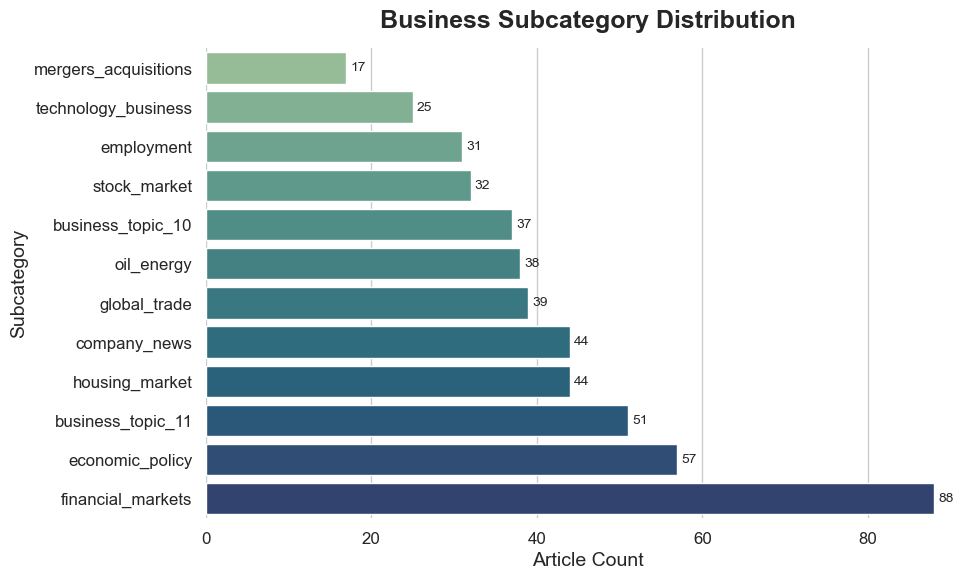

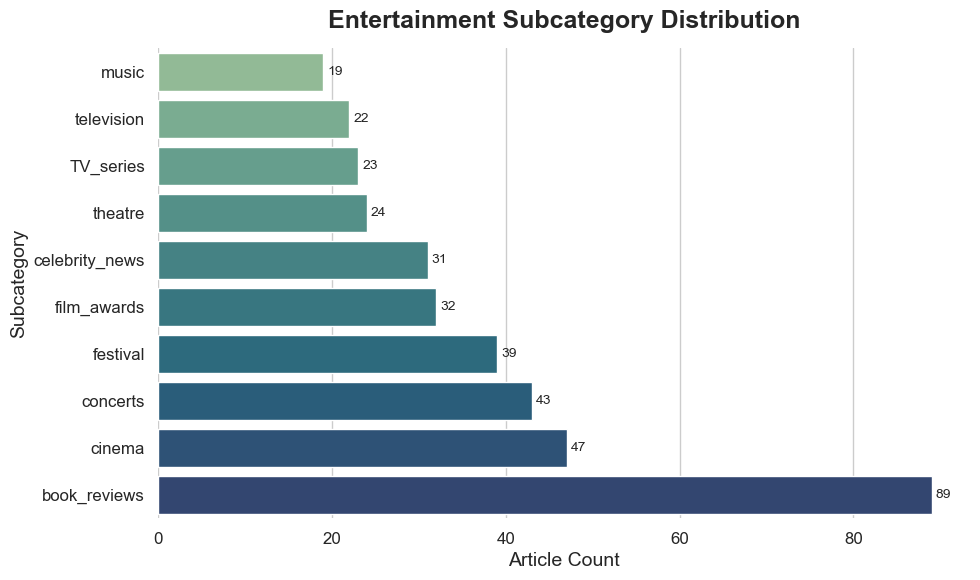

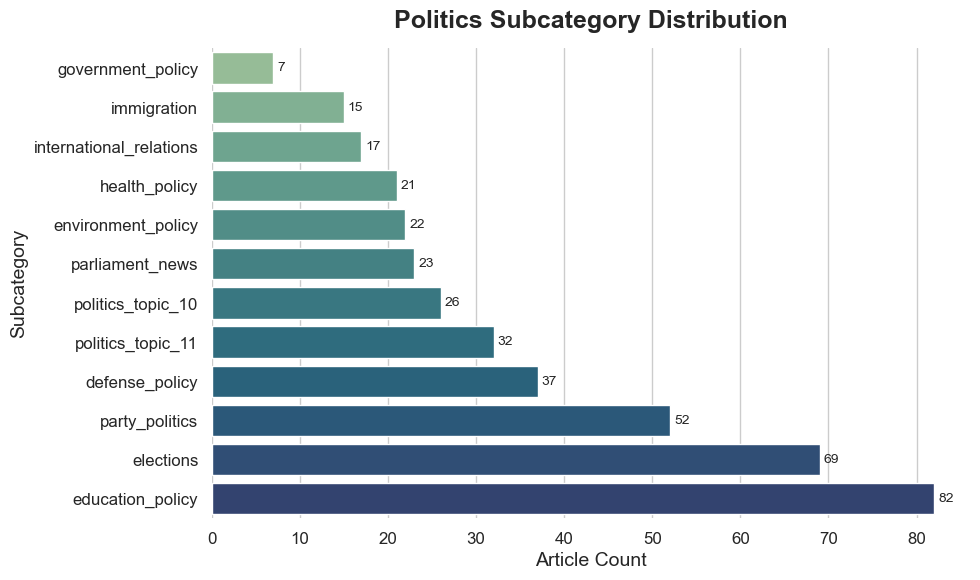

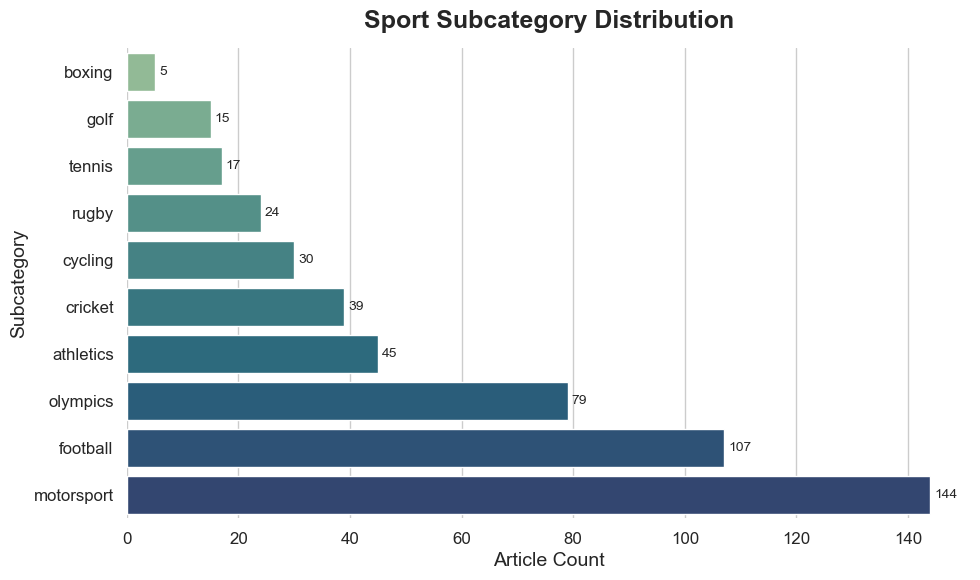

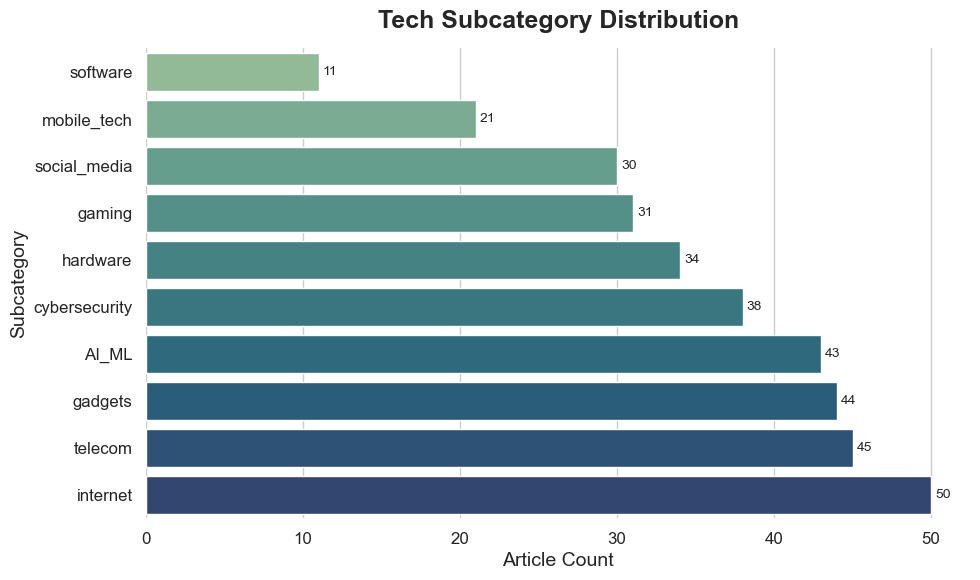

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Prepare Seaborn theme for a modern look
sns.set_theme(style="whitegrid", font_scale=1.1, palette="muted")

# Create individual plots per category
categories = counts_sorted['category'].unique()

for cat in categories:
    plt.figure(figsize=(10, 6))

    # Filter data for the category
    data_cat = counts_sorted[counts_sorted['category'] == cat].sort_values(by='count', ascending=True)

    # Barplot with color gradients
    colors = sns.color_palette("crest", len(data_cat))
    ax = sns.barplot(
        x='count',
        y='subcategory',
        data=data_cat,
        palette=colors
    )

    # Titles and labels
    ax.set_title(f"{cat.capitalize()} Subcategory Distribution", fontsize=18, weight='bold', pad=15)
    ax.set_xlabel('Article Count', fontsize=14)
    ax.set_ylabel('Subcategory', fontsize=14)

    # Add value labels for clarity
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

    # Remove spines for a cleaner aesthetic
    sns.despine(left=True, bottom=True)

    # Tight layout and display
    plt.tight_layout()
    plt.show()


In [11]:
import pandas as pd
import plotly.express as px

# Use your counts_sorted DataFrame here

category_colors = {
    'business': '#636EFA',
    'entertainment': '#EF553B',
    'politics': '#00CC96',
    'sport': '#AB63FA',
    'tech': '#FFA15A'
}

fig = px.sunburst(
    counts_sorted,
    path=['category', 'subcategory'],
    values='count',
    color='category',
    color_discrete_map=category_colors,
    title='Interactive BBC Category and Subcategory Distribution (Distinct Rings)'
)

fig.update_layout(
    margin=dict(t=50, l=0, r=0, b=0),
    title_font_size=22,
    uniformtext=dict(minsize=10, mode='hide')
)

fig.show()


In [3]:
import os
import pandas as pd
from sklearn.datasets import load_files
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import spacy
import ollama

# ---------------------- SETUP ----------------------
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# ---------------------- CONFIG ----------------------
subcategory_lists = {
    'entertainment': ['music', 'cinema', 'theatre', 'television', 'celebrity_news', 'film_awards', 'book_reviews', 'TV_series', 'concerts', 'festival'],
    'business': ['stock_market', 'company_news', 'mergers_acquisitions', 'economic_policy', 'oil_energy', 'employment', 'housing_market', 'global_trade', 'technology_business', 'financial_markets'],
    'sport': ['football', 'cricket', 'rugby', 'tennis', 'olympics', 'athletics', 'motorsport', 'golf', 'boxing', 'cycling'],
    'politics': ['elections', 'government_policy', 'party_politics', 'international_relations', 'parliament_news', 'health_policy', 'education_policy', 'defense_policy', 'immigration', 'environment_policy'],
    'tech': ['mobile_tech', 'software', 'internet', 'hardware', 'gaming', 'cybersecurity', 'AI_ML', 'social_media', 'telecom', 'gadgets']
}

# ---------------------- LOAD BBC DATASET ----------------------
print("Loading BBC dataset...")
dataset = load_files(r"C:\Users\User\OneDrive\Desktop\BBC\data\bbc-fulltext\bbc", encoding="latin1", decode_error="replace")
df = pd.DataFrame({'text': dataset.data, 'category': dataset.target})
df['category'] = df['category'].apply(lambda i: dataset.target_names[i])

print(f"Original shape: {df.shape}")
df = df.drop_duplicates(subset='text')
print(f"After removing duplicates: {df.shape}")

# ---------------------- TEXT CLEANING ----------------------
print("Cleaning text...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered)

df['clean_text'] = df['text'].apply(clean_text)

# ---------------------- SUBCATEGORY CLASSIFICATION ----------------------
def extract_subcategory(model_output, subcategories):
    output = model_output.lower()
    for subcat in subcategories:
        if subcat.lower() in output:
            return subcat
    return "unknown"

def classify_article_with_gemma(text, category):
    subcategories = subcategory_lists.get(category, [])
    if not subcategories:
        return "unknown"

    prompt = (
        f"Given the following BBC news article under the category '{category}', "
        f"classify it into ONE of the following subcategories: {', '.join(subcategories)}.\n\n"
        f"Return ONLY the subcategory name. No explanation. No punctuation.\n\n"
        f"Article:\n{text[:3000]}"
    )

    try:
        response = ollama.chat(model='gemma:2b', messages=[
            {"role": "system", "content": "You are a helpful classification assistant."},
            {"role": "user", "content": prompt}
        ])
        raw_output = response['message']['content'].strip()
        subcategory = extract_subcategory(raw_output, subcategories)

    except Exception as e:
        print(f"[ERROR] {e}")
        subcategory = "error"

    return subcategory

print("Classifying articles with Gemma 2B...")
tqdm.pandas()

df['subcategory'] = df.progress_apply(lambda row: classify_article_with_gemma(row['clean_text'], row['category']), axis=1)

# ---------------------- NAMED ENTITY RECOGNITION + ROLES ----------------------
print("Extracting media personalities using spaCy...")
nlp = spacy.load("en_core_web_sm")
role_keywords = {
    "politician": ["minister", "mp", "senator", "president", "prime minister", "government"],
    "musician": ["singer", "band", "musician", "album", "song"],
    "actor": ["actor", "actress", "film", "movie", "tv"],
    "tv_personality": ["tv", "host", "presenter", "show"]
}

def extract_named_entities_with_roles(text):
    doc = nlp(text)
    persons = set([ent.text for ent in doc.ents if ent.label_ == "PERSON"])
    roles = {}
    for person in persons:
        if person in roles:  # Avoid repeats
            continue
        lower_text = text.lower()
        assigned_role = "unknown"
        for role, keywords in role_keywords.items():
            if any(keyword in lower_text for keyword in keywords):
                assigned_role = role
                break
        roles[person] = assigned_role
    return roles

df['entities_with_roles'] = df['text'].apply(extract_named_entities_with_roles)

# ---------------------- APRIL EVENT SUMMARY ----------------------
print("Extracting April event summaries...")

def summarize_april_event(text):
    prompt = (
        f"Summarize this BBC news article, focusing only on what took place or is scheduled to take place in April. "
        f"Return only a brief summary without any introductory phrases or explanations.\n\n{text}"
    )
    try:
        response = ollama.chat(model='gemma:2b', messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes news articles."},
            {"role": "user", "content": prompt}
        ])
        return response['message']['content'].strip().replace('\n', ' ')
    except Exception as e:
        print(f"[SUMMARY ERROR] {e}")
        return ""

def extract_april_summary(text):
    if "april" in text.lower():
        return summarize_april_event(text)
    else:
        return ""

df['april_summary'] = df['text'].apply(extract_april_summary)

# ---------------------- SAVE RESULTS ----------------------
df[['text', 'category', 'subcategory', 'entities_with_roles', 'april_summary']].to_csv("classified_bbc_articles_with_entities_final.csv", index=False)
print("✅ Done. Results saved to 'classified_bbc_articles_with_entities_final.csv'.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading BBC dataset...
Original shape: (2225, 2)
After removing duplicates: (2127, 2)
Cleaning text...
Classifying articles with Gemma 2B...


100%|████████████████████████████████████████████████████████████████████████████| 2127/2127 [6:15:55<00:00, 10.60s/it]


Extracting media personalities using spaCy...
Extracting April event summaries...
✅ Done. Results saved to 'classified_bbc_articles_with_entities_final.csv'.


In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L12-v2')
print("Model loaded ✅")

Model loaded ✅


In [4]:
# ---------------------- COHERENCE SCORE EVALUATION ----------------------
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
from tqdm import tqdm

print("\n🔍 Evaluating semantic coherence for LLM subcategory predictions...")

# Reload from CSV to be safe
df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\BBC\src\classified_bbc_articles_with_entities_final.csv")

# Load sentence embedding model
embedding_model = SentenceTransformer('all-MiniLM-L12-v2')  # Or 'all-MiniLM-L6-v2' for faster

def compute_coherence(text, subcategory):
    try:
        if not isinstance(subcategory, str) or subcategory.lower() == "unknown":
            return np.nan
        # Convert label to readable format
        label_text = subcategory.replace('_', ' ')
        # Encode text and label
        text_emb = embedding_model.encode(text[:512], convert_to_tensor=True)
        label_emb = embedding_model.encode(label_text, convert_to_tensor=True)
        # Cosine similarity as coherence score
        score = util.cos_sim(text_emb, label_emb).item()
        return round(score, 4)
    except Exception as e:
        print(f"[COHERENCE ERROR] {e}")
        return np.nan

# Use tqdm progress_apply for progress bar
tqdm.pandas()

df['coherence_score'] = df.progress_apply(lambda row: compute_coherence(row['text'], row['subcategory']), axis=1)

# Print average coherence per top-level category
print("\n📈 Average coherence scores by category:")
for category in df['category'].unique():
    avg_score = df[df['category'] == category]['coherence_score'].mean()
    print(f" - {category}: {avg_score:.4f}")

# Save updated CSV with coherence scores
df.to_csv("classified_bbc_articles_with_coherence.csv", index=False)
print("✅ Coherence scores saved to 'classified_bbc_articles_with_coherence.csv'.")




🔍 Evaluating semantic coherence for LLM subcategory predictions...


100%|██████████████████████████████████████████████████████████████████████████████| 2127/2127 [02:41<00:00, 13.16it/s]



📈 Average coherence scores by category:
 - business: 0.2287
 - tech: 0.2262
 - politics: 0.2587
 - sport: 0.2696
 - entertainment: 0.1960
✅ Coherence scores saved to 'classified_bbc_articles_with_coherence.csv'.


In [5]:
df

,text,category,subcategory,entities_with_roles,april_summary,coherence_score
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,stock_market,"{'European Businessman': 'politician', 'Iain F...",NaN,0.1768
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech,mobile_tech,"{'Xbox Live': 'politician', 'Blizzard': 'polit...",NaN,0.0305
2,MSPs hear renewed climate warning\n\nClimate c...,politics,environment_policy,{},NaN,0.5046
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,unknown,"{'Justyna Bak': 'politician', 'Jo Pavey': 'pol...",NaN,NaN
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics,elections,"{'Adrian Hilton': 'politician', ""John Major's""...",NaN,0.2618
...,...,...,...,...,...,...
2122,EU fraud clampdown urged\n\nEU member states a...,politics,elections,"{'Edward Leigh': 'politician', 'Jorg Wojahn': ...",NaN,0.1059
2123,Tindall aiming to earn Lions spot\n\nBath and ...,sport,rugby,"{'Clive Woodward': 'politician', 'Gloucester':...","Sure, here is a summary of the article: Mike ...",0.3465
2124,Jamelia's return to the top\n\nR&B star Jameli...,entertainment,music,"{'Chris Martin': 'politician', 'Jamelia': 'pol...",NaN,0.1856
2125,Oscars steer clear of controversy\n\nThe Oscar...,entertainment,cinema,"{'Adolf Hitler': 'politician', 'Tim Dams': 'po...",NaN,0.3468


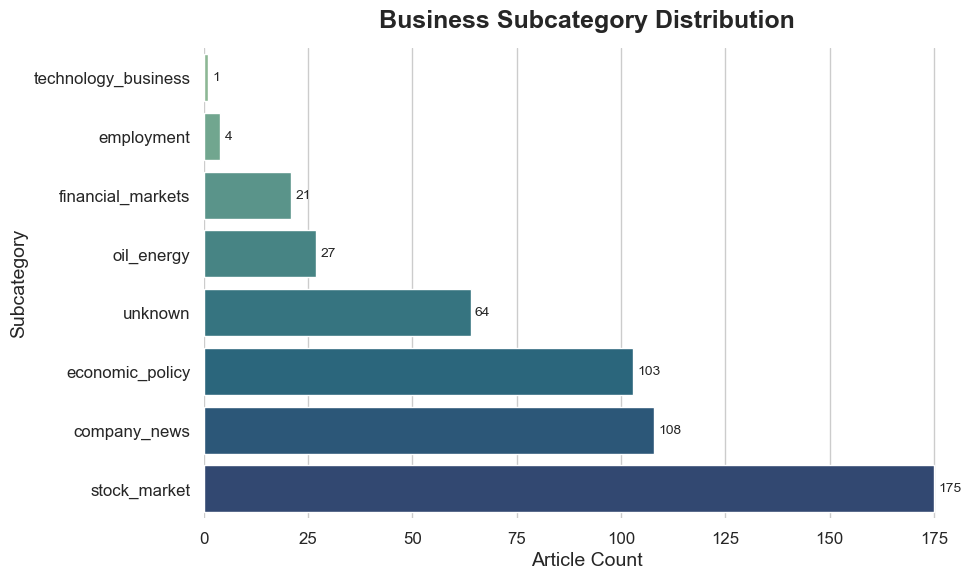

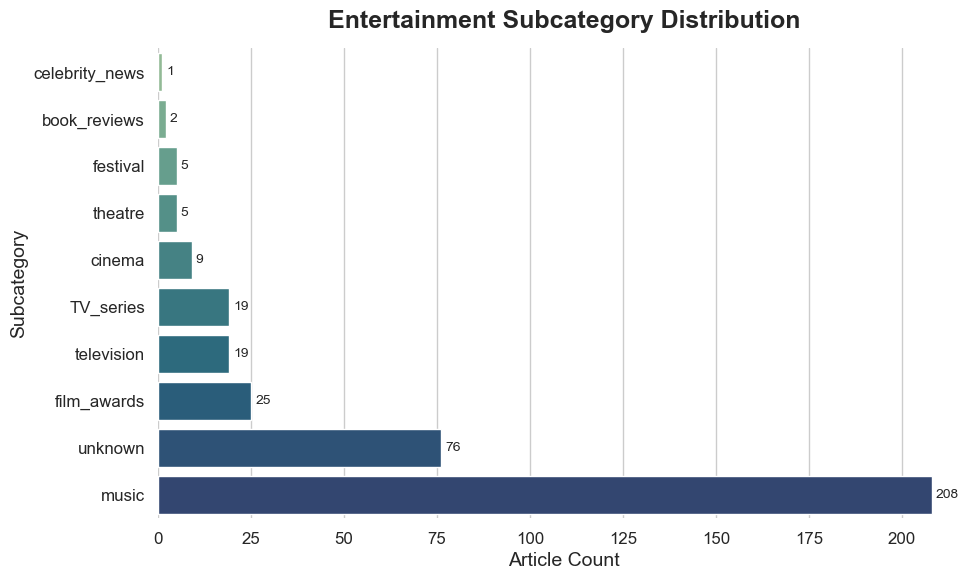

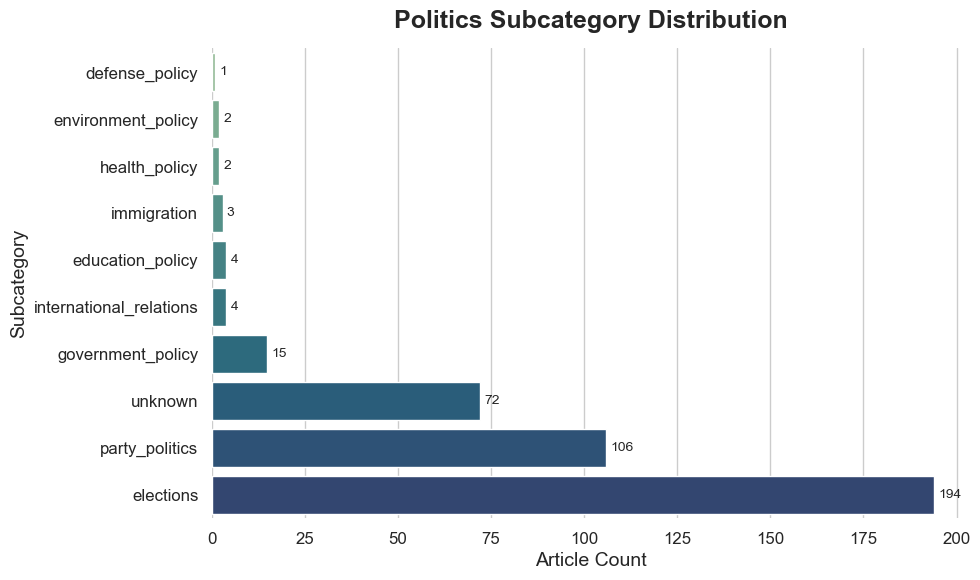

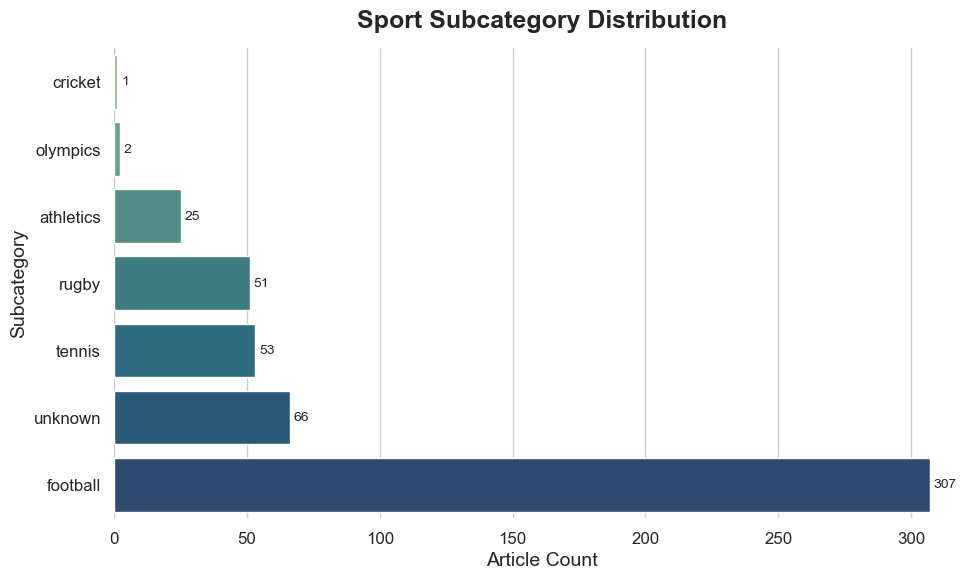

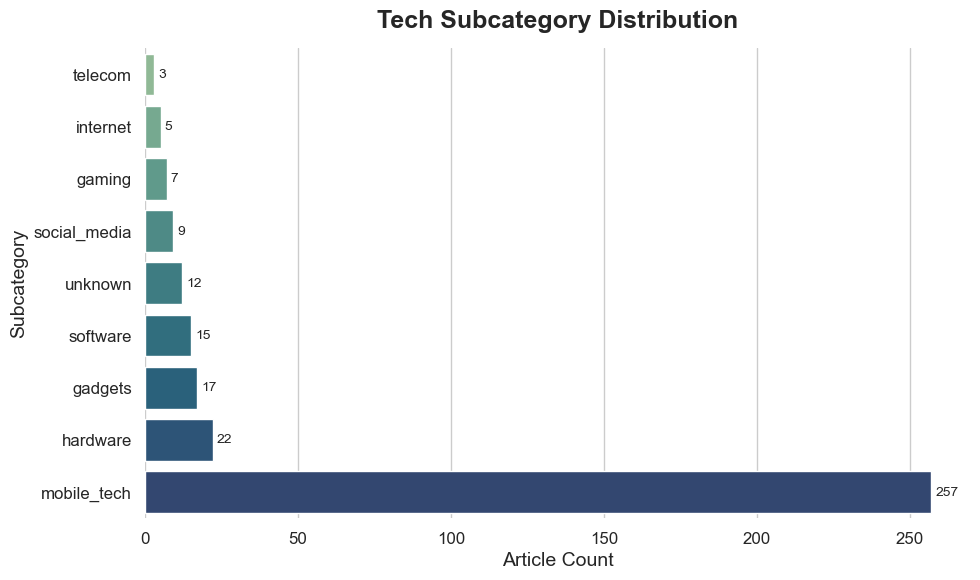

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved results if not already in memory
df = pd.read_csv("classified_bbc_articles_with_entities.csv")

# Count articles per subcategory within each category
counts = df.groupby(['category', 'subcategory']).size().reset_index(name='count')

# Sort subcategories by count within each category
counts_sorted = counts.sort_values(by=['category', 'count'], ascending=[True, False])

# Seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.1, palette="muted")

# Plot each category
categories = counts_sorted['category'].unique()

for cat in categories:
    plt.figure(figsize=(10, 6))
    data_cat = counts_sorted[counts_sorted['category'] == cat].sort_values(by='count', ascending=True)

    colors = sns.color_palette("crest", len(data_cat))
    ax = sns.barplot(
        x='count',
        y='subcategory',
        data=data_cat,
        palette=colors
    )

    # Titles and labels
    ax.set_title(f"{cat.capitalize()} Subcategory Distribution", fontsize=18, weight='bold', pad=15)
    ax.set_xlabel('Article Count', fontsize=14)
    ax.set_ylabel('Subcategory', fontsize=14)

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


In [13]:
counts_gemma2 = df[['category', 'subcategory']].value_counts().reset_index(name='count')

# Sort by 'category' and then 'subcategory'
counts_gemma2_sorted = counts_gemma2.sort_values(by=['category', 'subcategory'], ascending=[True, True]).reset_index(drop=True)

counts_gemma2_sorted

,category,subcategory,count
0,business,company_news,108
1,business,economic_policy,103
2,business,employment,4
3,business,financial_markets,21
4,business,oil_energy,27
5,business,stock_market,175
6,business,technology_business,1
7,business,unknown,64
8,entertainment,TV_series,19
9,entertainment,book_reviews,2


In [14]:
import pandas as pd
import plotly.express as px

# Use your counts_sorted DataFrame here

category_colors = {
    'business': '#636EFA',
    'entertainment': '#EF553B',
    'politics': '#00CC96',
    'sport': '#AB63FA',
    'tech': '#FFA15A'
}

fig = px.sunburst(
    counts_gemma2_sorted,
    path=['category', 'subcategory'],
    values='count',
    color='category',
    color_discrete_map=category_colors,
    title='Interactive BBC Category and Subcategory Distribution (Distinct Rings)'
)

fig.update_layout(
    margin=dict(t=50, l=0, r=0, b=0),
    title_font_size=22,
    uniformtext=dict(minsize=10, mode='hide')
)

fig.show()
